In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from datetime import timedelta

In [2]:
def lerp(start, end, t):
	r = start[0] + (end[0] - start[0]) * t
	g = start[1] + (end[1] - start[1]) * t
	b = start[2] + (end[2] - start[2]) * t
	a = start[3] + (end[3] - start[3]) * t
	return (r / 255.0, g / 255.0, b / 255.0, a)

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [3]:
# Max 1 820 277
hex_list = ['#85ff00', '#fff100', '#ffaa04', '#ff0000', '#dc00ff', '#6700d4', '#1200db', '#0a014a']
scales = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
colors = [(0x85, 0xff, 0x00, 1.0), (0xff, 0xf1, 0x00, 1.0), (0xff, 0xaa, 0x04, 1.0), (0xff, 0x00, 0x00, 1.0), (0xdc, 0x00, 0xff, 1.0), (0x67, 0x00, 0xd4, 1.0), (0x12, 0x00, 0xdb, 1.0), (0x12, 0x00, 0xdb, 1.0), (0x0a, 0x01, 0x4a, 1.0), ]

In [4]:
df = pd.read_csv('exposed_by_type.csv')
type_names = list(set(df.type.unique()) - set(["?"]))

dates = sorted(list(df.date.unique()))

done = 0
output = {}
first_appearance = {}
for _type in type_names:
	c = []
	for d in range(len(dates)):
		if not _type in list(df[(df.date == dates[d])]['type']) or df[(df.date == dates[d]) & (df['type'] == _type)]['count'].iloc[0] == 0:
			c += [(0, 0, 0, 0)]
		else:
			first_appearance[_type] = dates[d]
			v = df[(df.date == dates[d]) & (df['type'] == _type)]['count'].iloc[0]
			idx = -1
			for s in range(len(scales) - 1):
				if scales[s] < v and v <= scales[s+1]:
					idx = s
			if idx == -1:
				c += [lerp(colors[-1], colors[-1], 0.5)]
			else:
				c += [lerp(colors[idx], colors[idx+1], (v - scales[idx])/(scales[idx + 1] - scales[idx]))]
	done += 1
	print(f'{str(done).zfill(len(str(len(type_names))))}/{len(type_names)}: {_type}')
	output[_type] = c


01/36: router
02/36: wireless-access-point
03/36: voip
04/36: plc
05/36: video-system
06/36: smart-thermostat
07/36: email
08/36: wireless-repeater
09/36: device-management
10/36: printer
11/36: conferencing-system
12/36: web-enabled-controller
13/36: smart-home-management
14/36: wireless-controller
15/36: power-device
16/36: power-management
17/36: other-software
18/36: hmi-panel
19/36: local-monitoring-system
20/36: ip-pbx
21/36: appliance
22/36: cms
23/36: healthcare-system
24/36: device-managament
25/36: nas
26/36: smart-building-management
27/36: hypervisor
28/36: embedded-system
29/36: application-delivery-controller
30/36: web-panel
31/36: firewall
32/36: security-management
33/36: load-balancer
34/36: home-appliance
35/36: scanner
36/36: smart-alarm


In [5]:
from json import dumps
jsonified = dumps(output)
with open('./exposed-type.json', 'w') as f:
    f.write(jsonified)
    f.close()

In [6]:
# Sort infection names initial date (color tuple not 0 0 0 0 ) then alphabetical
appearance = {}
for _type in type_names:
    for c in range(len(output[_type])):
        if output[_type][c][0] != 0 or output[_type][c][1] != 0 or output[_type][c][2] != 0 or output[_type][c][3] != 0:
            appearance[_type] = c
            break

appearance_inv = {i: [] for i in range(len(dates))}

for v in sorted(list(appearance.items()), key=lambda x: x[1]):
    appearance_inv[v[1]] += [v[0]]

for i in range(len(dates)):
    if len(appearance_inv[i]) == 0:
        del(appearance_inv[i])
    else:
        appearance_inv[i] = sorted(appearance_inv[i])

type_names_sorted = [x for xs in [v for k, v in appearance_inv.items()] for x in xs][::-1]

In [7]:
norm=LogNorm(vmin=1, vmax=9999999)
cmappable = ScalarMappable(norm=norm, cmap=get_continuous_cmap(hex_list=hex_list))

In [8]:
dates = sorted(list(df.date.unique()))
m_dates = mdates.num2date(mdates.datestr2num(sorted(dates)))
m_dates[-1]

datetime.datetime(2022, 5, 4, 0, 0, tzinfo=datetime.timezone.utc)

01/36: web-panel
02/36: email
03/36: application-delivery-controller
04/36: load-balancer
05/36: embedded-system
06/36: smart-thermostat
07/36: security-management
08/36: other-software
09/36: wireless-repeater
10/36: scanner
11/36: power-device
12/36: device-managament
13/36: cms
14/36: conferencing-system
15/36: voip
16/36: hmi-panel
17/36: web-enabled-controller
18/36: home-appliance
19/36: plc
20/36: device-management
21/36: smart-building-management
22/36: wireless-controller
23/36: wireless-access-point
24/36: video-system
25/36: smart-home-management
26/36: smart-alarm
27/36: router
28/36: printer
29/36: power-management
30/36: nas
31/36: local-monitoring-system
32/36: ip-pbx
33/36: hypervisor
34/36: healthcare-system
35/36: firewall
36/36: appliance


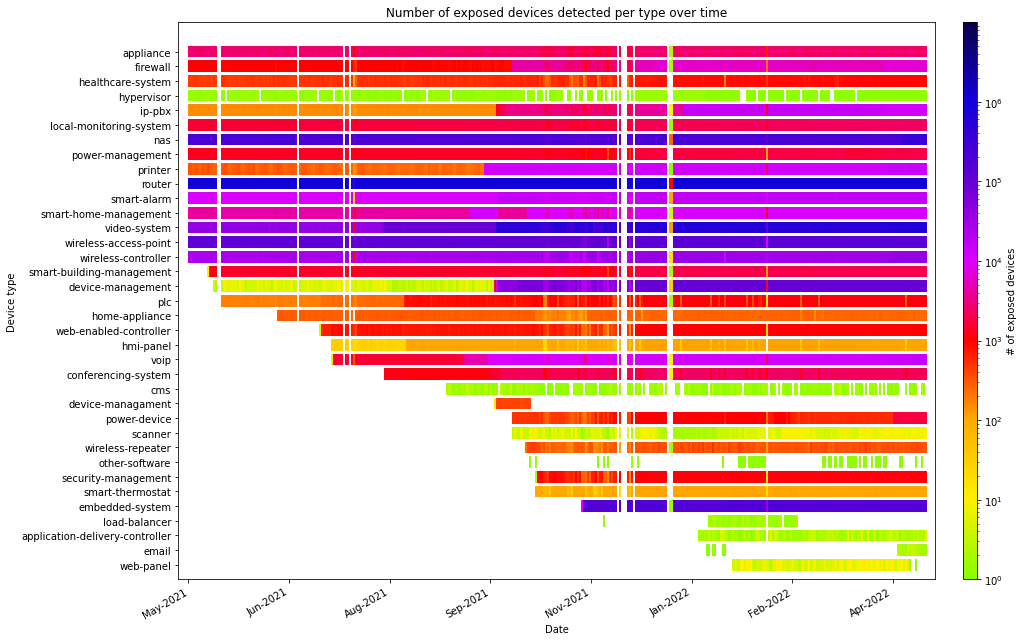

In [9]:

plt.rcParams["figure.figsize"] = (16.54, 11.38)

fig, ax = plt.subplots(figsize=(16.54, 11.38))
y = 0
done = 0

for _type in type_names_sorted:
	for c in range(len(output[_type])):
		ax.barh(y, 1, left= m_dates[c], height=0.8, align='center', color=output[_type][c])
	y += 1
	done += 1
	print(f'{str(done).zfill(len(str(len(type_names))))}/{len(type_names)}: {_type}')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
ax.axis('tight')
ax.set_xlim([m_dates[0] - timedelta(days=5), m_dates[-1] + timedelta(days=5)])
ax.set_ylim([-1, len(type_names) + 1])
ax.set_yticks(np.arange(len(type_names)))
ax.set_yticklabels(type_names_sorted)

ax.set_xlabel('Date')
ax.set_ylabel('Device type')

fig.autofmt_xdate()

cb =fig.colorbar(cmappable, aspect=40, pad=0.03)
cb.ax.set_ylabel('# of exposed devices')

ax.set_title("Number of exposed devices detected per type over time")

plt.savefig('../images/exposed-bytype-better.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.2, dpi=300)
plt.show()